_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote , Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat GPT, used for autompletion and debugging.*

# Coding Lab 6

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex. For details, see [Ecker et al. 2014](https://www.cell.com/neuron/pdf/S0896-6273(14)00104-4.pdf).

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone https://github.com/berenslab/poisson-gpfa` to the parent directory and have the following directory structure:


```
├── data/
│   └── nds_cl_6_data.mat
├── poisson-gpfa/
├── notebooks
│   └── CodingLab6.ipynb
├── matplotlib_style.txt
├── requirements.txt
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have a different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nds_cl_6_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# style
import seaborn as sns

# poisson-gpfa
import sys
import os

current = os.getcwd()
if not current.endswith("notebooks"):
    os.chdir(os.path.join(current, "notebooks"))
    print("Changed working directory to:", os.getcwd())

sys.path.append("../poisson-gpfa/")
sys.path.append("../poisson-gpfa/funs")

import funs.util as util
import funs.engine as engine

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-31 01:03:11Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.22.2

sklearn: 1.4.2

sys       : 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
numpy     : 1.26.4
matplotlib: 3.8.3
scipy     : 1.12.0
seaborn   : 0.13.2

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

Hint: You can use `util.dataset?`, `engine.PPGPFAfit?` or `util.initializeParams?` to find out more about the provided package.

*Grading: 3 pts*

In [4]:
# ---------------------------------
# simulate a training set (0.5 pts)
# ---------------------------------

# Initialize random number generator
rng = np.random.default_rng(seed=42)
# Specify dataset & fitting parameters
toy_params = util.dataset(
    trialDur=1000,
    numTrials=100,
    seed=42,
    binSize=50,
    xdim=1,
    ydim=30,
)

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 3.464 Hz.


### Fit the model

In [5]:
# -----------------------
# fit the model (0.5 pts)
# -----------------------

# Initialize parameters using Poisson-PCA
toy_init = util.initializeParams(1, 30, experiment=toy_params)
# choose sensible parameters and run fit
toy_model = engine.PPGPFAfit(
    toy_params, initParams=toy_init, maxEMiter=50, EMmode="Batch"
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -260.8846
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [6]:
# some useful functions
def allTrialsState(fit: engine.PPGPFAfit, p) -> np.ndarray:
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p, 0])
    print("Length of post_mean:", len(fit.infRes["post_mean"]))
    for i in range(len(fit.infRes["post_mean"])):
        x = np.concatenate((x, fit.infRes["post_mean"][i]), axis=1)
    return x


def allTrialsX(training_set: util.dataset) -> np.ndarray:
    """Reshape the ground truth
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt = np.concatenate((x_gt, training_set.data[i]["X"][0]), axis=0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [7]:
# All trials latent state vector
x_est = allTrialsState(toy_model, 1)
x_true = allTrialsX(toy_params)

Length of post_mean: 100


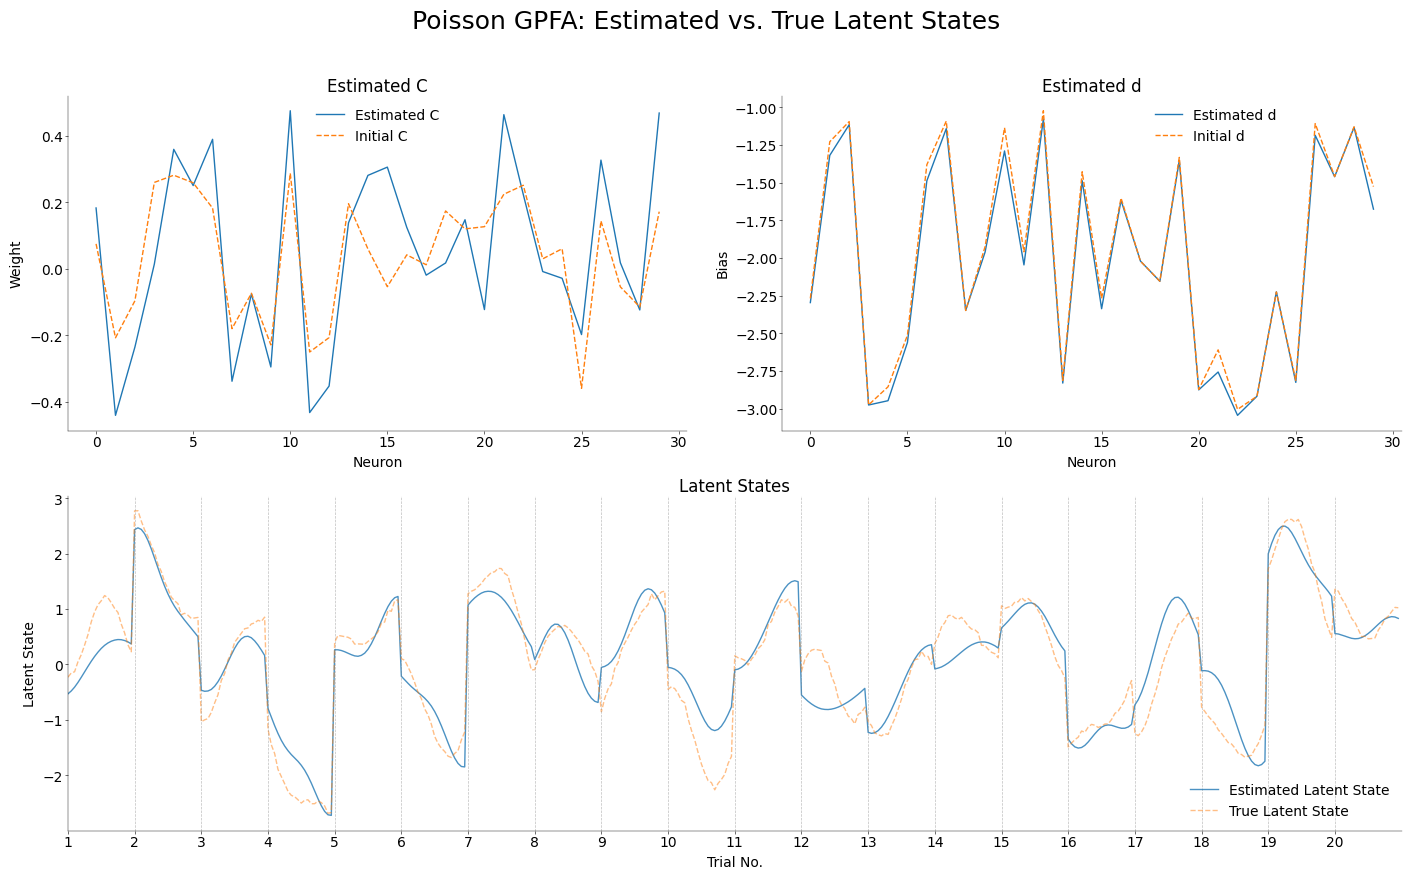

In [13]:
# ------------------------------------------------------
# Plot ground truth vs. inferred model
# Plot the weights `C`, biases `d` and latent states (2 pts)
# ------------------------------------------------------


# add plot
fig, ax = plt.subplot_mosaic([["C", "d"], ["latent", "latent"]], figsize=(14, 8))
# For d & C consider also plotting the optimal weights as a dotted line for reference
est_params = toy_model.optimParams

len_latent = (
    toy_params.trialDur // toy_params.binSize
)  # integer number of bins per trial

ax["C"].plot(
    est_params["C"][:, 0],
    label="Estimated C",
    color="tab:blue",
)
ax["C"].plot(
    toy_init["C"][:, 0],
    label="Initial C",
    color="tab:orange",
    linestyle="--",
)
ax["C"].set_title("Estimated C")
ax["C"].set_xlabel("Neuron")
ax["C"].set_ylabel("Weight")
ax["C"].legend()

ax["d"].plot(
    est_params["d"],
    label="Estimated d",
    color="tab:blue",
)
ax["d"].plot(
    toy_init["d"],
    label="Initial d",
    color="tab:orange",
    linestyle="--",
)
ax["d"].set_title("Estimated d")
ax["d"].set_xlabel("Neuron")
ax["d"].set_ylabel("Bias")
ax["d"].legend(loc="upper center", bbox_to_anchor=(0.7, 1.0))

# For the latent states consider seperating each trial by a vertical line
# plot only for a subset of trials

start_trial = 0
end_trial = 20


ax["latent"].plot(
    x_est[0, len_latent * start_trial : len_latent * end_trial],
    color="tab:blue",
    alpha=0.8,
    label="Estimated Latent State",
)
ax["latent"].plot(
    x_true[len_latent * start_trial : len_latent * end_trial]
    * -1,  # invert the sign for visualization
    color="tab:orange",
    alpha=0.5,
    linestyle="--",
    label="True Latent State",
)
ax["latent"].set_title("Latent States")
ax["latent"].set_xlabel("Trial No.")
ax["latent"].set_ylabel("Latent State")
ax["latent"].set_xlim(start_trial * len_latent, end_trial * len_latent)
# Add vertical lines to separate trials
# Add legend
ax["latent"].set_xticks(
    np.arange(start_trial * len_latent, end_trial * len_latent, len_latent)
)
ax["latent"].set_xticklabels(
    np.arange(start_trial + 1, end_trial + 1),
)
ax["latent"].legend()
# add vertical lines to separate trials
for i in range(1, toy_params.numTrials):
    ax["latent"].axvline(
        x=i * len_latent,
        color="gray",
        linestyle="--",
        alpha=0.5,
        lw=0.5,
        label=f"Trial {i}",
    )
# Show the plot
plt.suptitle("Poisson GPFA: Estimated vs. True Latent States", fontsize=18, y=1.08)
plt.show()

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 4 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [9]:
class EckerDataset:
    """Loosy class"""

    def __init__(
        self,
        path: str,
        subject_id: int = 0,
        ydim: int = 55,
        trialDur: int = 2000,
        binSize: int = 100,
        numTrials: int = 100,
        ydimData: bool = False,
        numTrData: bool = True,
    ):
        # T = binSize #int(trialDur/binSize)
        T = int(trialDur / binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time = matdat["spikeTimes"][:, trial_id][0]
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append(
                {
                    "Y": matdat["spikeCounts"][:, :, trial_id],
                    "spike_time": matdat["spikeTimes"][:, trial_id],
                }
            )
        self.T = T
        self.trial_durs = trial_durs
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [10]:
path = "../data/nds_cl_6_data.mat"
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the sum of the squared errors (SSE) on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

### Derivation for log-likelihood

_You can add your calculations in_ $\LaTeX$ _here_.

$p_\lambda(x_t) = \ldots$

$L(\lambda_k; x_1, ..., x_N) = \ldots$ 

$log(L) = l(\lambda_k; x_1, ..., x_N) = \ldots$

In [11]:
# ------------------------------
# Perfom cross validation (1 pt)
# ------------------------------


# do the actual cross validation
cross_val = util.crossValidation(data, numTrainingTrials=80, numTestTrials=20)

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                    3 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:   3 of   3, nPLL: = -406.0619Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the SSE of a constant rate model (or Poisson likelihood if you did the optional part above). Note: We assume a constant firing rate across trials, but not necessarily across time.

In [ ]:
# --------------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models (1 pt)
# --------------------------------------------------------------------------------
train_set, test_set = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)

# compute baseline error
# A constant rate model predicts the mean firing rate for each neuron at each time bin,
# averaged over the training trials.

# 1. Calculate mean rates per bin for each neuron from the training set
num_neurons = train_set.ydim
num_bins_per_trial = train_set.T
mean_rates_train = np.zeros((num_neurons, num_bins_per_trial))

for trial_data in train_set.data:
    mean_rates_train += trial_data["Y"]  # Summing up spike counts for each neuron/bin
mean_rates_train /= train_set.numTrials  # Averaging over training trials

# 2. Calculate SSE on the test set using these mean rates
baseline_error_sse = 0
for trial_data in test_set.data:
    actual_spikes_test_trial = trial_data["Y"]
    # Prediction for each bin in this test trial is the mean_rates_train
    squared_errors_trial = (actual_spikes_test_trial - mean_rates_train) ** 2
    baseline_error_sse += np.sum(squared_errors_trial)

baseline_error = baseline_error_sse
print(f"Baseline SSE (0 latents): {baseline_error}")

Baseline SSE (0 latents): 41378.97499999999


C:\Users\Julius\AppData\Local\Temp\ipykernel_17328\3073164283.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


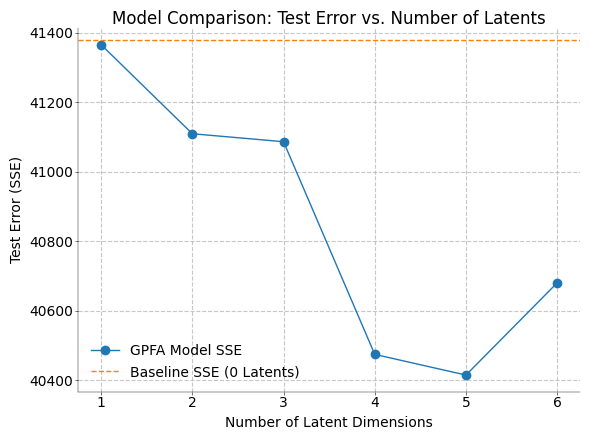

In [ ]:
# -------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models
# and answer the questions below (1+1 pts)
# -------------------------------------------------------------------------

# Your plot here
fig, ax = plt.subplots(figsize=(6, 4.5))  # Adjusted figsize

# X-axis: Latent dimensionalities (1 to maxXdim)
# Assuming cross_val.maxXdim holds the maximum number of dimensions tested
# If cross_val.errs has 5 elements, this will be 1 to 5.
latent_dims = np.arange(1, len(cross_val.errs) + 1)


# plot model error
ax.plot(
    latent_dims,  # Use the correctly determined latent dimensions
    cross_val.errs,  # Corrected attribute name
    marker="o",
    linestyle="-",
    label="GPFA Model SSE",  # More descriptive label
    color="tab:blue",
)
# plot baseline
ax.axhline(
    baseline_error,
    linestyle="--",
    label="Baseline SSE (0 Latents)",
    color="tab:orange",  # Adjusted label and color
)
ax.set_xlabel("Number of Latent Dimensions")  # More descriptive label
ax.set_ylabel("Test Error (SSE)")
ax.set_title("Model Comparison: Test Error vs. Number of Latents")
ax.set_xticks(latent_dims)  # Ensure ticks for each latent dimension tested
ax.legend()
ax.grid(True, which="both", linestyle="--", alpha=0.7)  # Added more grid details
plt.tight_layout()
plt.show()

### Questions

Is the baseline error (0 latents) about what you expect in relation to the other models? Why or why not?

_YOUR ANSWER GOES HERE_

Can you identify a "best model". If so, which is it and what does this say about the structure of the latent state?

_YOUR ANSWER GOES HERE_

## Task 3. Visualization: population rasters and latent state.
Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

In [ ]:
from numpy import matlib

# Your plot here
fig, axs = plt.subplots(10, 2, figsize=(14, 14))

ts = np.linspace(0, 2000, 100)
xa = 0.15
xs = 0.7 * xa * np.sin(ts / 1000 * 3.4 * 2 * np.pi) + xa

with sns.axes_style("ticks"):
    for ntrial, ax in enumerate(axs.flat):
        x = range(50, 2000, 100)  # assume binsize of 100ms

        # --------------------------------------------------------
        # plot the raster for each neuron and latent state (2 pts)
        # --------------------------------------------------------

        # hint: can be plotted on top of the corresponding raster
        
        # sort neurons by weight

        if ntrial == 0:
            ax.legend()
        if ntrial == 1:
            ax.plot([1000, 2000], [-30, -30], color="green")
            ax.text(1300, -50, "1sec")
        if ntrial < 2:
            ax.plot(ts, (xs * 40) + data.ydim, "k", color="black")

        ax.set_yticks([])
        ax.set_xticks([])

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\otimes\mu^T \odot \exp(CC^T)+\mu\cdot \mathbb{I} - \mu\otimes\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

In [ ]:
# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of
# the approximation using the provide equations (2 pts)
# --------------------------------------------------------------


def cov(fit: engine.PPGPFAfit) -> np.ndarray:
    
    return c, mu


# --------------------------------------------------------------
# Plot the covariance matrix of
# (1) the observed data
# (2) its approximation using 1 latent variable
# (3) its approximation using 5 latent variable
# and explain how they compare (1+1 pts).
# --------------------------------------------------------------

obs_corr = np.cov(data.all_raster)
opt_r1, mu1 = cov(xval.fits[0])
opt_r5, mu5 = cov(xval.fits[4])

# HINT: Think about which type of colormap and ranges are appropriate here. 

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
# add plot to visualize the differences in the covariance matrices

### Questions

What do you see / expect to see?

_YOUR ANSWER GOES HERE_